# Predict

In [41]:
from transformers import  AutoTokenizer, TextClassificationPipeline, AutoModelForSequenceClassification
import numpy as np
from datasets import Dataset
import pandas as pd

In [42]:
model = AutoModelForSequenceClassification.from_pretrained('../../../Files/ROBERTA_checkpoint-462')
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                         max_length=512,
                                         padding='max_length', 
                                         truncation=True, 
                                         add_special_tokens = True, 
                                         return_tensors='pt')
                                    
myclassifier = TextClassificationPipeline(model=model, 
                                        tokenizer=tokenizer, 
                                        truncation=True, 
                                        max_length=500, 
                                        device=0, #the GPU device I used
                                        batch_size=32, # I think this has no influence on accuracy, only on speed (larger value occupies more GPU memory)
                                        return_all_scores=True)

In [43]:
#Load and prepare pre-processed Dataset
test = pd.read_csv('../../../Files/Submissions/train/test2_v2.csv', sep='|')
data = Dataset.from_pandas(test[['cleanText', 'label']]) #Using a Huggingface Dataset allows for greater parallelization 


In [44]:
#Prediction
results = myclassifier(data['cleanText'])

In [45]:
score = np.zeros((0, 3))
for prediction in results:
    score = np.append(score,[[prediction[0]['score'],prediction[1]['score'],prediction[2]['score']]], axis=0)

In [46]:
score

array([[0.20455265, 0.78140801, 0.01403933],
       [0.0705155 , 0.0595773 , 0.8699072 ],
       [0.08932303, 0.89836162, 0.01231542],
       ...,
       [0.93337709, 0.04163786, 0.02498501],
       [0.71731067, 0.11761972, 0.16506965],
       [0.06461152, 0.02937859, 0.90600991]])

# Evaluate Predictions

In [48]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from keras.utils import to_categorical

In [49]:
def calc_roc_curve(y_test, y_score, classifier):
    if classifier == "1":
        n_classes = 2
    else:
        n_classes = y_test.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

   
    return fpr, tpr, roc_auc, n_classes

In [50]:
def plot_results_b(y_test, y_pred, model, perf_class, classifier="2"):
    if classifier == "1":
        labels = {0: "Non-Covid", 1: "Covid"}
    elif classifier == "2":
        labels = {0: "Anti-Vaccine", 1: "Neutral", 2: "Pro-Vaccine"}
    fig = plt.figure(f"{model} Performance Evaluation", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    font = {"weight": "bold"}
    fpr, tpr, roc_auc, n_classes = calc_roc_curve(y_test, y_pred, classifier)
    ax0 = fig.add_subplot(axgrid[0:3, :])

    ax0.set_title(f"Receiver Operating Characteristic (ROC) Curve for {model}", fontdict=font)
     # Plot all ROC curves
    lw = 2

     # Plot all ROC curves
    ax0.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    ax0.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        ax0.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(labels[i], roc_auc[i]),
        )

    ax0.plot([0, 1], [0, 1], "k--", lw=lw)
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
   
    ax0.legend(loc="lower right")

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.set_title("Confusion Matrics", fontdict=font)
    y_score_max = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    y_score_label = np.argmax(y_score_max, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax1 = sns.heatmap(df2, annot=True)
    ax1.set(xlabel='Predicted', ylabel='Actual', xticklabels=labels.values(), yticklabels=labels.values())
    ax1.set_title("Confusion matrix", fontdict=font)

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    acc = metrics.accuracy_score(y_test_label, y_score_label)
    f1 = metrics.f1_score(y_test_label, y_score_label, average='macro')
    roc_auc = metrics.roc_auc_score(y_test, y_score_max, multi_class='ovo')
    ax2.set_title("Performance Metrics", fontdict=font )
    ax2.text(0.23, 0.85, f"Model: {model}", fontdict=font)
    ax2.text(0.23, 0.75, f"Model Type: {perf_class}")
    ax2.text(0.18, 0.68, "--------------------------------------------------")
    ax2.text(0.23, 0.6, f"Accuracy is {round(acc, 3)}")
    ax2.text(0.23, 0.5, f"F1 is {round(f1,3)}")
    ax2.text(0.23, 0.4, f"ROC-AUC is {round(roc_auc, 3)}")
    ax2.text(0.18, 0.33, "---------------------------------------------------")
  
    ax2.set_axis_off()

    fig.tight_layout()
    plt.show()

In [51]:
y_true = pd.read_csv('../../../Files/Submissions/train/test2_v2.csv', sep='|')
y_true = to_categorical(y_true['label'], 3)

In [52]:
y_conf = pd.read_csv('../../../Files/Submissions/train/Roberta_C2_v5.csv', sep='|')[['conf_0', 'conf_1', 'conf_2']]
y_pred_roberta = y_conf.to_numpy()

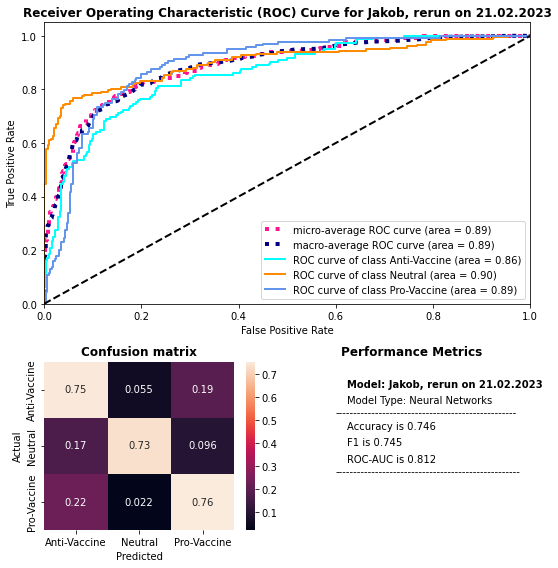

In [53]:
plot_results_b(y_true, y_pred_roberta, "Jakob, rerun on 21.02.2023", "Neural Networks", "2")

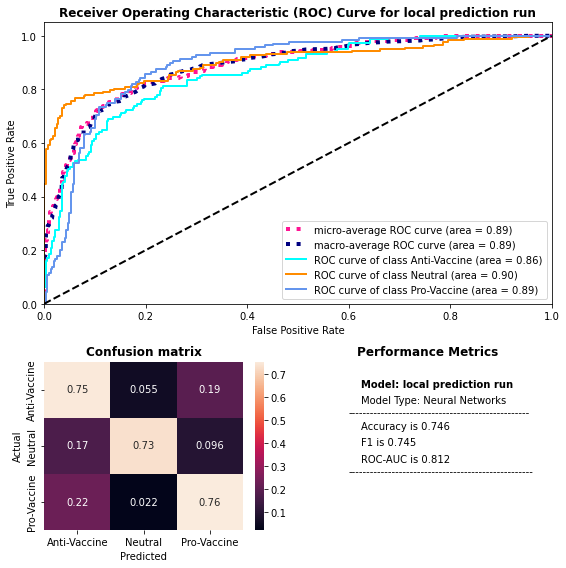

In [40]:
plot_results_b(y_true, score, "local prediction run", "Neural Networks", "2")